## Import libraries

In [1]:
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
data = scio.loadmat('../monkeydata_training.mat')
trials = data['trial'].reshape(100,8)

## Design matrix

In [41]:
def average_fr(spike_data):
    [_,len_data] = spike_data.shape
    
    avg_fr = sum(np.transpose(spike_data))
    avg_fr = avg_fr / len_data
    return avg_fr

def calculate_design_matrix(spike_data, training_size):
    design_mat  = np.zeros((training_size*8,4,98))
    temp = 0
    
    for i in range(training_size):
        for j in range(8):
            design_mat[temp,0,:] = average_fr(spike_data[i,j][1][:,:])
            design_mat[temp,1,:] = average_fr(spike_data[i,j][1][:,1:300])
            design_mat[temp,2,:] = average_fr(spike_data[i,j][1][:,301:-100])
            design_mat[temp,3,:] = average_fr(spike_data[i,j][1][:,-99:])
            temp += 1
               
    return design_mat

In [42]:
# Get spike data, fr = firing rate
# Each trial: fr_avg, fr_planning, fr_moving, fr_end --> (trials,4,98)
design_mat = calculate_design_matrix(trials,80)

## 1D CNN - Feedforward

In [229]:
class FeedForward(nn.Module):
    def __init__(self,num_layers,layer_size,dropout):
        super(FeedForward, self).__init__()
        self.fc1  = nn.Linear(101, layer_size) 
        self.drop = nn.Dropout(p=dropout)
        
        if num_layers == 2:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
            )
        elif num_layers == 3:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.Dropout(p=dropout),
                nn.ReLU()
            )
        elif num_layers == 4:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.Dropout(p=dropout),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.Dropout(p=dropout),
                nn.ReLU()
            )
       
        self.fc2 = nn.Linear(layer_size, 2)
    
    def forward(self, x):
        output = self.fc1(x)
        output = self.drop(output)
        output = self.feedforward(output)
        output = self.fc2(output)   
        return output

## 2D CNN 

In [7]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(200,100,kernel_size=1,padding='same') 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(100,100,kernel_size=1,padding='same') 
        self.relu2 = nn.ReLU()

        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout(p=0.1)

        self.fc1 = nn.Linear(400, 100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
        output = self.relu2(output)
    
        output = self.flat(output)
        output = self.drop(output)
        
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

## RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Train & test functions

In [240]:
def train_model(model, X, Y, learning_rate=0.01, num_epochs=500):
        X = torch.FloatTensor(X)
        Y = torch.FloatTensor(Y)
        
        dataset = torch.utils.data.TensorDataset(X, Y)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
                sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=100000, drop_last=False))

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        model.train();

        loss_history = []
        for _ in tqdm.trange(num_epochs):
                for _, (inputs, targets) in enumerate(data_loader):
                        optimizer.zero_grad()
                        y_pred = model(inputs)
                        loss = criterion(y_pred, targets)
                        loss.backward()
                        optimizer.step()
                        loss_history.append(loss.item())
        plt.figure()
        plt.plot(loss_history)
                        
        return model

In [237]:
def test_model(model, X, Y, ns):
    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)
    
    model.eval();
    y_pred = model(X) 

    length = len(y_pred)
    results = np.zeros((length,2))
    target  = np.zeros((length,2))
    for i in range(length):
        target[i,:]  = Y[i].detach().numpy()
        results[i,:] = y_pred[i].detach().numpy()
            
    error_x = (target[:,0] - results[:,0])
    error_y = (target[:,1] - results[:,1])
    
    plt.figure()
    _, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(error_x)
    axs[0].plot(ns)
    axs[0].title.set_text('X - error')
    axs[1].plot(error_y)
    axs[1].plot(ns)
    axs[1].title.set_text('Y - error')
    
    print('x: ' + str(np.mean(abs(error_x))))
    print('y: ' + str(np.mean(abs(error_y))))

## Workflow

In [45]:
# Prep data for CNN
# Use data 300ms long in 20ms intervals
# Input  -- (num_segments,98,300) OR 300,98???
# Output -- (deltaX, deltaY)

# Spikes  -- trials[:,:][1] -- (98, length)
# HandPos -- trials[:,:][2] -- (3,  length)

training = trials[:80,:]
testing  = trials[80:,:]

In [105]:
# Train with raw data
training_X = []
training_Y = []
for i in range(75):
    for j in range(8):
        spikes  = training[i,j][1]
        handpos = training[i,j][2]
        for n in range(int(np.floor((spikes.shape[1]-300)/20))):
            training_X.append(spikes[:,n*20:n*20+300])
            training_Y.append(((handpos[1,n*20+299]-handpos[1,n*20])*100, (handpos[2,n*20+299]-handpos[2,n*20])*100))

training_X = torch.FloatTensor(training_X)
training_Y = torch.FloatTensor(training_Y)

testing_X = []
testing_Y = []
for i in range(25):
    for j in range(8):
        spikes  = testing[i,j][1]
        handpos = testing[i,j][2]
        for n in range(int(np.floor((spikes.shape[1]-300)/20))):
            testing_X.append(spikes[:,n*20:n*20+300])
            testing_Y.append(((handpos[1,n*20+299]-handpos[1,n*20])*100, (handpos[2,n*20+299]-handpos[2,n*20])*100))

testing_X = torch.FloatTensor(testing_X)
testing_Y = torch.FloatTensor(testing_Y)

In [238]:
# Train with firing rate
training_X = []
training_Y = []
testing_X = []
testing_Y = []
n_data = []

for j in range(8):
    X_train_direction = []
    Y_train_direction = []
    X_test_direction = []
    Y_test_direction = []
    
    for i in range(80):
        [_, spikes, handpos] = training[i,j]
       
        for n in range(0,spikes.shape[1]-300,20):
            data = np.zeros((101))
            data[0]   = n
            data[1:3] = handpos[1:2,n+279] 
            data[3:]  = average_fr(spikes[:,n:n+300])
            if n>1:
                print(data[1:3], data[3:5])
            X_train_direction.append(data) 
            Y_train_direction.append(((handpos[1,n+299]-handpos[1,n+279]), (handpos[2,n+299]-handpos[2,n+279])))

    ns= []
    for i in range(20):
        [_, spikes, handpos] = testing[i,j]
        
        for n in range(0,spikes.shape[1]-300,20):
            data = np.zeros((101))
            data[0]   = n
            data[1:3] = handpos[1:2,n+279]
            data[3:]  = average_fr(spikes[:,n:n+300])
            X_test_direction.append(data)
            Y_test_direction.append(((handpos[1,n+299]-handpos[1,n+279]), (handpos[2,n+299]-handpos[2,n+279])))
            if n==0:
                ns.append(3)
            else:
                ns.append(0)
    n_data.append(ns)
           
    training_X.append(X_train_direction)
    training_Y.append(Y_train_direction)
    testing_X.append(X_test_direction)
    testing_Y.append(Y_test_direction)

[-7.25902597 -7.25902597] [0.01666667 0.00666667]
[-6.17832322 -6.17832322] [0.02       0.00666667]
[-3.69400974 -3.69400974] [0.02333333 0.00333333]
[2.10056364 2.10056364] [0.02666667 0.00333333]
[9.87617841 9.87617841] [0.02666667 0.00333333]
[17.50178669 17.50178669] [0.02666667 0.00333333]
[25.29388888 25.29388888] [0.03       0.00333333]
[31.82009744 31.82009744] [0.03       0.00333333]
[37.15027652 37.15027652] [0.03       0.00333333]
[40.90524157 40.90524157] [0.03       0.00333333]
[43.63217812 43.63217812] [0.03       0.00333333]
[45.63046924 45.63046924] [0.02666667 0.00333333]
[46.76562965 46.76562965] [0.02333333 0.00333333]
[48.83375686 48.83375686] [0.02666667 0.00333333]
[49.70893845 49.70893845] [0.02333333 0.00333333]
[49.1793005 49.1793005] [0.02       0.00333333]
[47.87816671 47.87816671] [0.02333333 0.00333333]
[46.86993982 46.86993982] [0.02333333 0.00333333]
[-11.63260924 -11.63260924] [0.02       0.00333333]
[-9.95425315 -9.95425315] [0.02333333 0.00333333]
[-7.

In [241]:
## Create 8 models!
models = []
for i in range (8):
    feedforward = FeedForward(2,15,0.6)
    feedforward = train_model(feedforward, training_X[i], training_Y[i], 0.0005, 7500)
    models.append(feedforward)

 41%|████▏     | 3099/7500 [00:03<00:05, 791.26it/s]

x: nan
y: nan
x: nan
y: nan
x: nan
y: nan
x: nan
y: nan
x: nan
y: nan
x: nan
y: nan
x: nan
y: nan
x: nan
y: nan


<Figure size 432x288 with 0 Axes>

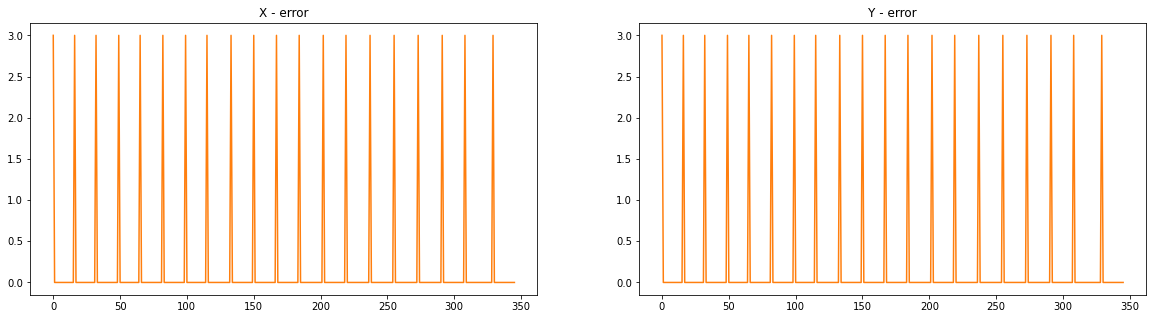

<Figure size 432x288 with 0 Axes>

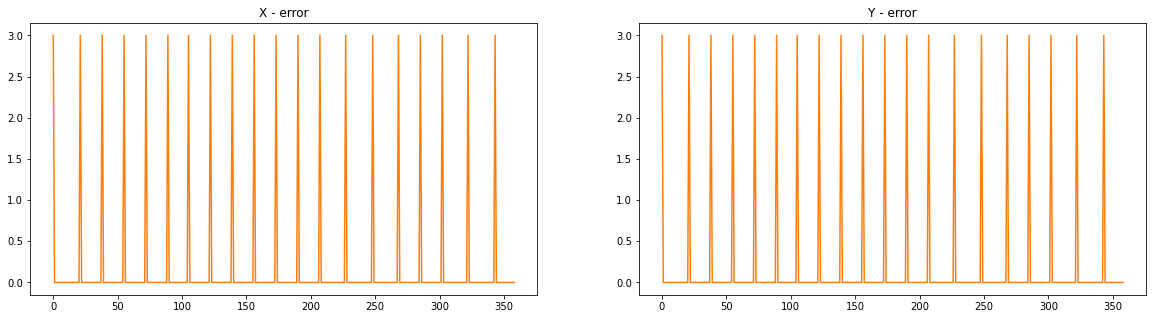

<Figure size 432x288 with 0 Axes>

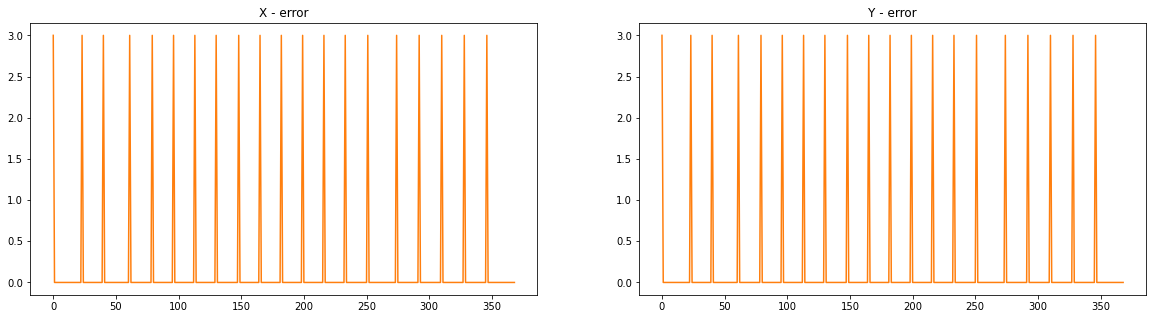

<Figure size 432x288 with 0 Axes>

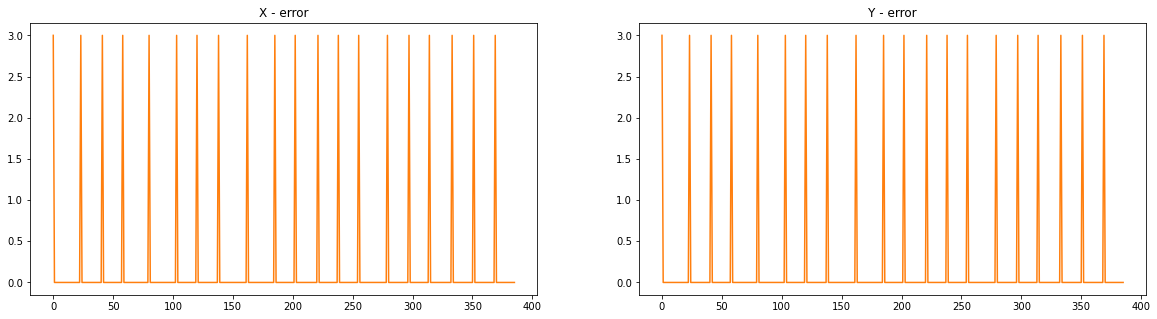

<Figure size 432x288 with 0 Axes>

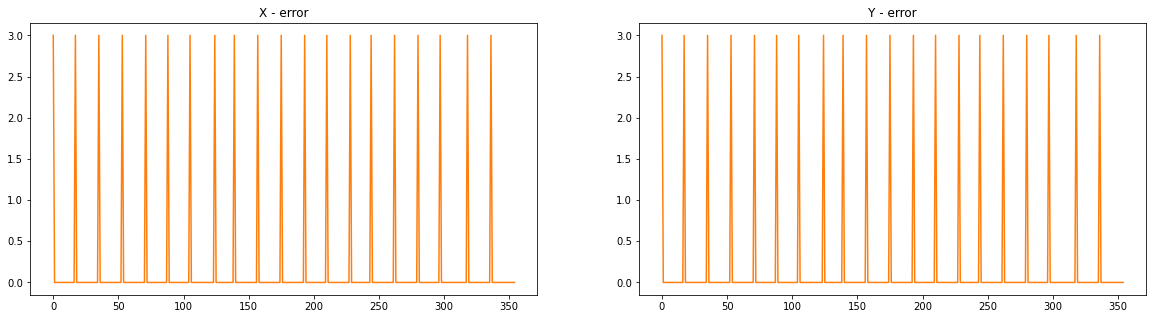

<Figure size 432x288 with 0 Axes>

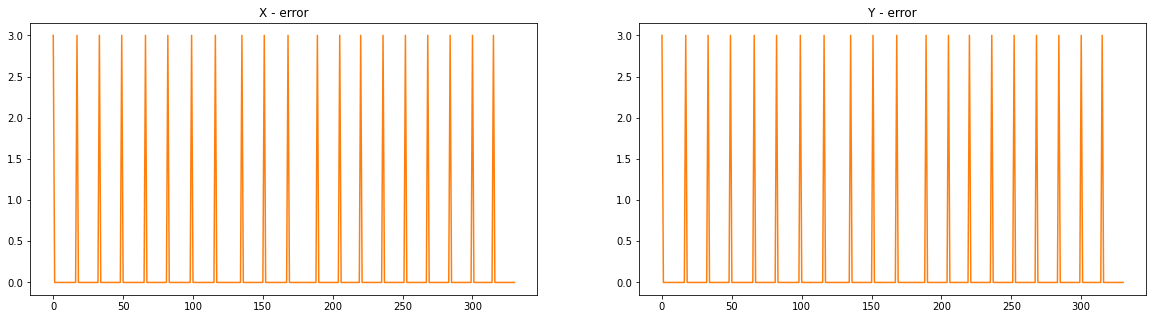

<Figure size 432x288 with 0 Axes>

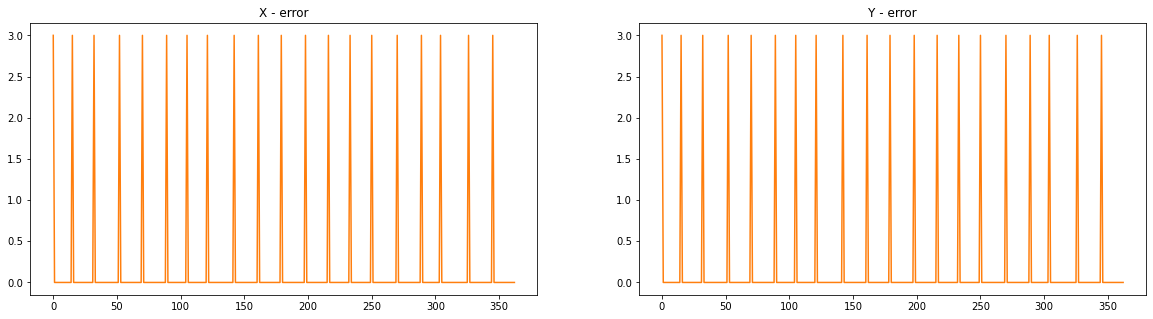

<Figure size 432x288 with 0 Axes>

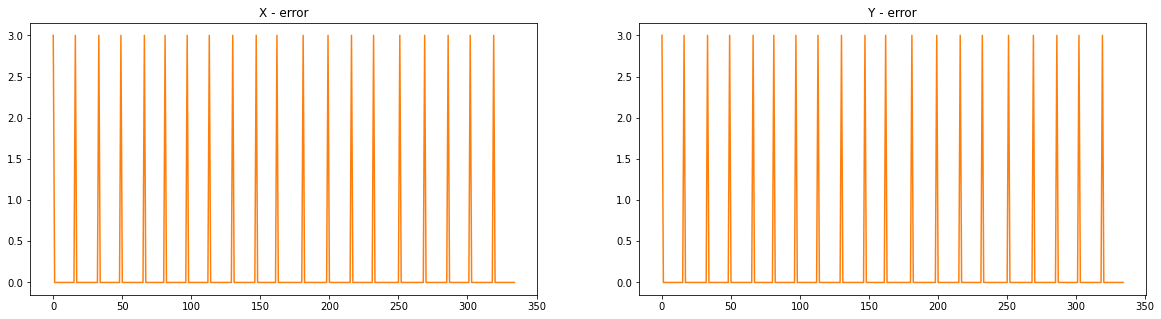

In [ ]:
for i in range (8):
    test_model(models[i], testing_X[i], testing_Y[i], n_data[i])